# Get GeoJSON

In [1]:
!wget https://github.com/9r4vEy4r6/host/raw/main/telangana_ac.geojson -O t.geojson

--2023-02-20 02:02:15--  https://github.com/9r4vEy4r6/host/raw/main/telangana_ac.geojson
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/9r4vEy4r6/host/main/telangana_ac.geojson [following]
--2023-02-20 02:02:15--  https://raw.githubusercontent.com/9r4vEy4r6/host/main/telangana_ac.geojson
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14324571 (14M) [text/plain]
Saving to: ‘t.geojson’

t.geojson           100%[===================>]  13.66M  --.-KB/s    in 0.1s    

2023-02-20 02:02:16 (123 MB/s) - ‘t.geojson’ saved [14324571/14324571]



In [2]:
!pip install --quiet geopandas pykrige

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.4/869.4 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 6.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [3]:
import geopandas as gpd
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
import pykrige.kriging_tools as kt
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Path, PathPatch
import pandas as pd
import numpy as np
import random

In [4]:
data = gpd.read_file("t.geojson")

In [5]:
data.to_crs(crs=3857) 
data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Basic Geoplot

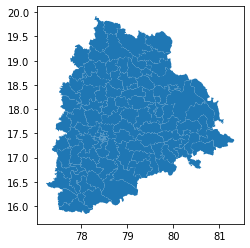

In [6]:
data.plot()

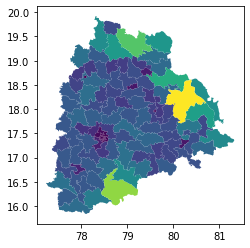

In [7]:
data.plot(column="shape_area")

In [8]:
import random
col = []
for i in range(119) : 
  r = random.random()
  if r > 0.8 : 
    col.append(r)
  else :
    col.append(float('nan'))

data2 = data.copy()
data2["shape_area"] = col

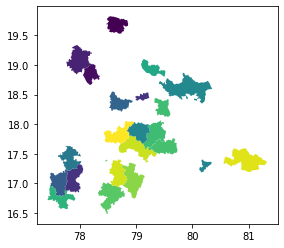

In [9]:
data2.plot(column="shape_area")

# Preparing Random Data

In [10]:
xmin, ymin, xmax, ymax = data.total_bounds
print(xmin, xmax)
print(ymin, ymax)

77.23560954500005 81.3211332490001
15.836347644999982 19.917992894000086


In [11]:
temp_data = []
N_POINTS = 10

T_MIN = 10
T_MAX = 50

def get_random_between(a=0, b=1) :
  return a + (random.random() * (b-a))

for i in range(N_POINTS) : 
  temp_data.append({
      "Lat" : get_random_between(ymin, ymax),
      "Lon" : get_random_between(xmin, xmax),
      "Z" : get_random_between(T_MIN, T_MAX)
  })

temp_data = pd.DataFrame(temp_data)
temp_data.head()

,Lat,Lon,Z
0,16.657015,80.115435,36.041520
1,18.098558,78.220467,16.515732
2,16.979760,79.396226,47.282201
3,16.678197,79.725207,45.760467
4,19.391588,77.402745,11.721707


In [12]:
lons=np.array(temp_data['Lon']) 
lats=np.array(temp_data['Lat']) 
zdata=np.array(temp_data['Z'])

In [13]:
xmin = xmin-0.01
xmax = xmax+0.01
ymin = ymin-0.01
ymax = ymax+0.01

grid_lon = np.linspace(xmin, xmax, 100)
grid_lat = np.linspace(ymin, ymax, 100)

# Demo Of Krigging

## Krigging Main

In [14]:
OK = OrdinaryKriging(lons, lats, zdata, variogram_model='gaussian', verbose=True, enable_plotting=False,nlags=20)
z1, ss1 = OK.execute('grid', grid_lon, grid_lat)
print (z1)

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 304.62685900993495
Full Sill: 309.0832971134324
Range: 3.8518279186397013
Nugget: 4.4564381034974945 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

[[2.9458166220033544 3.007268657005957 3.085959148693002 ...
  7.536257961945704 7.237945268468851 6.952884402460443]
 [2.862489845519555 2.937571718160287 3.0307425241705257 ...
  7.919012741795392 7.596117877378323 7.286910345871695]
 [2.7767961653143978 2.865613812861156 2.973381195669047 ...
  8.308432718456071 7.960677318848783 7.627046315638596]
 ...
 [15.558672203990351 15.7433184360092 15.942578364863401 ...
  19.730845529916948 19.167036159404194 18.613602591677655]
 [15.957947170674842 16.141438841455592 16.338919066581624 ...
  19.819274348434824 19.266410246710908 18.723595737674188]
 [16.34298898333258 16.52535513715047 16.721099556329836 ...
  19.9040

## Plotting

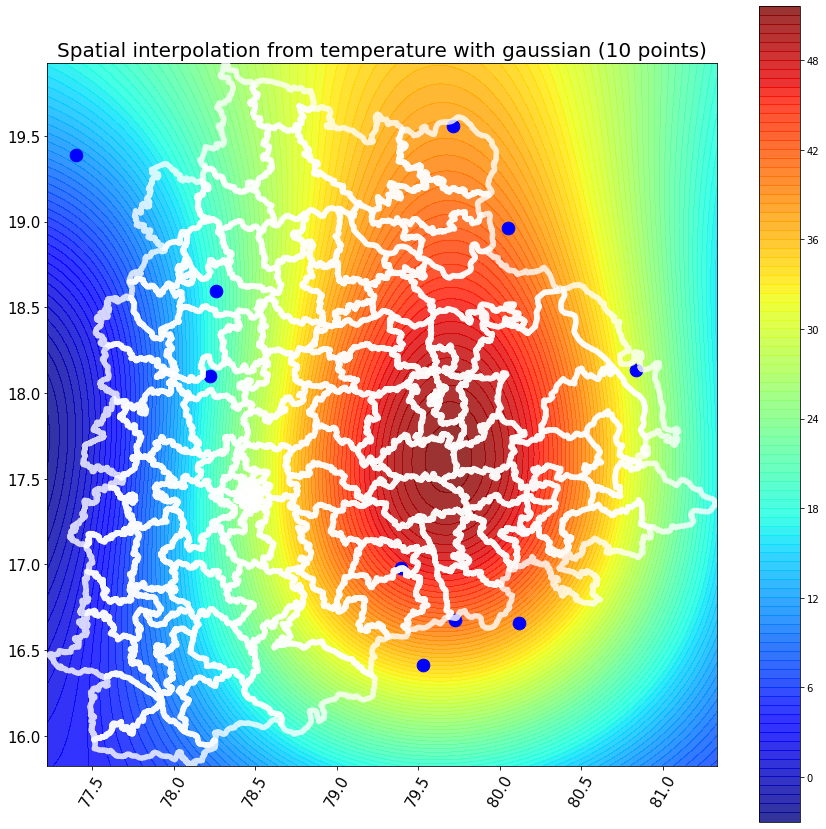

In [15]:
xintrp, yintrp = np.meshgrid(grid_lon, grid_lat) 
fig, ax = plt.subplots(figsize=(15,15))
#ax.scatter(lons, lats, s=len(lons), label='Input data')
boundarygeom = data.boundary.geometry
contour = plt.contourf(xintrp, yintrp, z1,len(z1),cmap=plt.cm.jet,alpha = 0.8) 
plt.colorbar(contour)
data.boundary.plot(ax=ax, color='white', alpha = 0.8, linewidth=5.5, edgecolor='black', zorder = 5)
npts = len(lons)
plt.scatter(lons, lats,marker='o',c='b',s=npts*16)
#plt.xlim(xmin,xmax)
#plt.ylim(ymin,ymax)
plt.xticks(fontsize = 15, rotation=60)
plt.yticks(fontsize = 15)
#Tempreture
plt.title('Spatial interpolation from temperature with gaussian (%d points)' % npts,fontsize = 20)
plt.show()

# Testing with various parameters

[Models](https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/variogram_models.html) <br />
[API Docs](https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/generated/pykrige.ok.OrdinaryKriging.html)

In [16]:
def krigAndPlot(lons, lats, zdata, model) : 
  OK = OrdinaryKriging(lons, lats, zdata, variogram_model=model, enable_plotting=False, nlags=20)
  z1, ss1 = OK.execute('grid', grid_lon, grid_lat)

  xintrp, yintrp = np.meshgrid(grid_lon, grid_lat) 
  fig, ax = plt.subplots(figsize=(15,15))
  boundarygeom = data.boundary.geometry
  contour = plt.contourf(xintrp, yintrp, z1,len(z1),cmap=plt.cm.jet,alpha = 0.8) 
  plt.colorbar(contour)
  data.boundary.plot(ax=ax, color='white', alpha = 0.8, linewidth=5.5, edgecolor='black', zorder = 5)
  npts = len(lons)
  plt.scatter(lons, lats,marker='o',c='b',s=npts*16)
  plt.xticks(fontsize = 15, rotation=60)
  plt.yticks(fontsize = 15)
  plt.title('Spatial interpolation from temperature with gaussian (%d points)' % npts,fontsize = 20)
  plt.show()

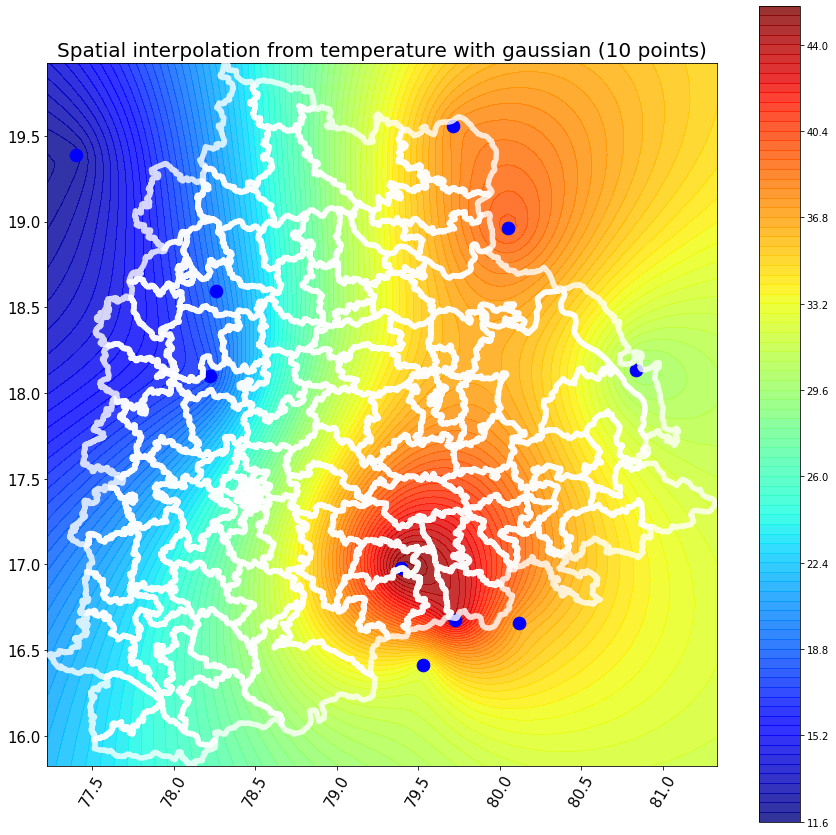

In [17]:
krigAndPlot(lons, lats, zdata, 'linear')

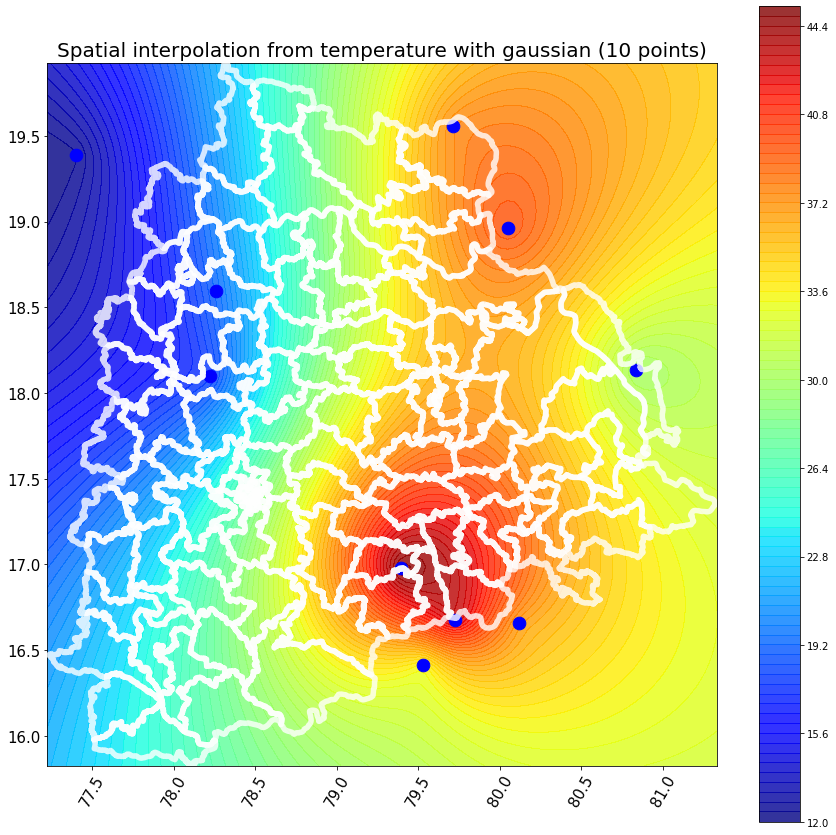

In [18]:
krigAndPlot(lons, lats, zdata, 'power')

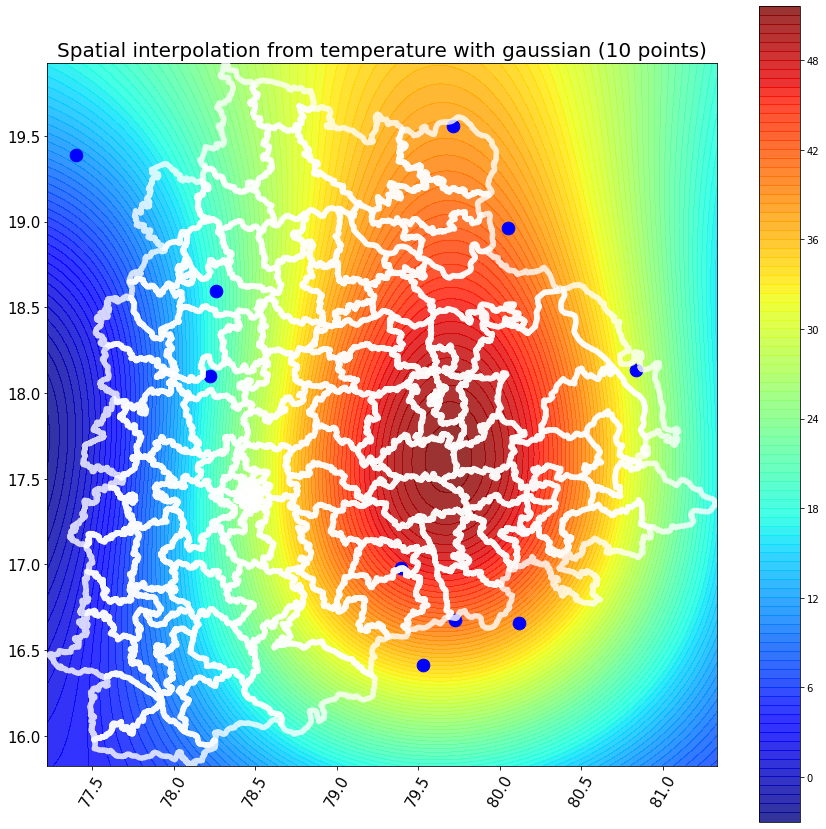

In [19]:
krigAndPlot(lons, lats, zdata, 'gaussian')

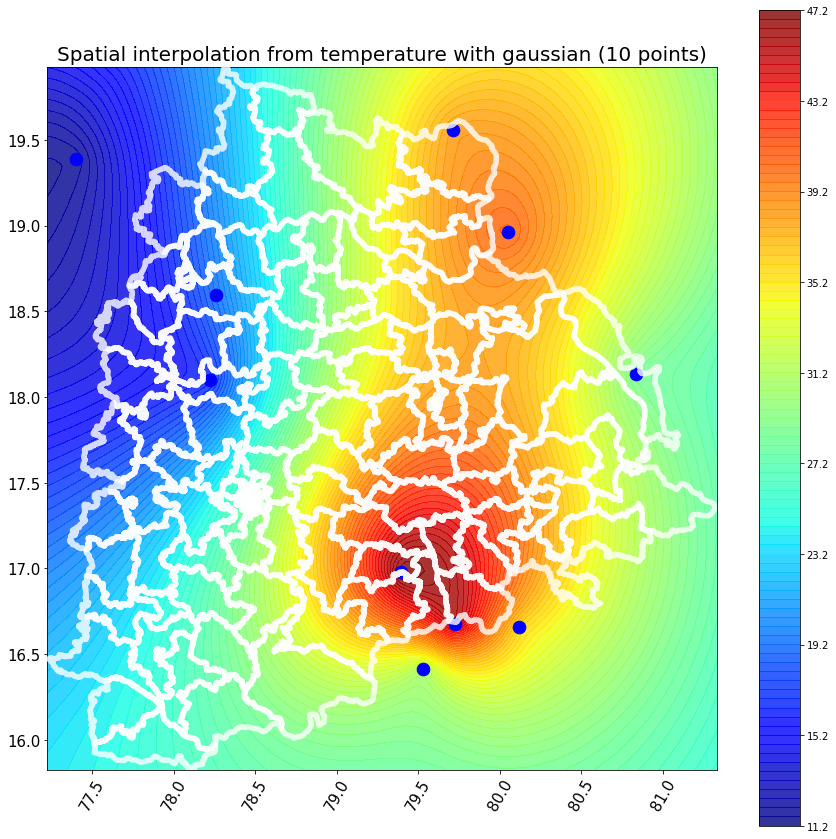

In [20]:
krigAndPlot(lons, lats, zdata, 'spherical')

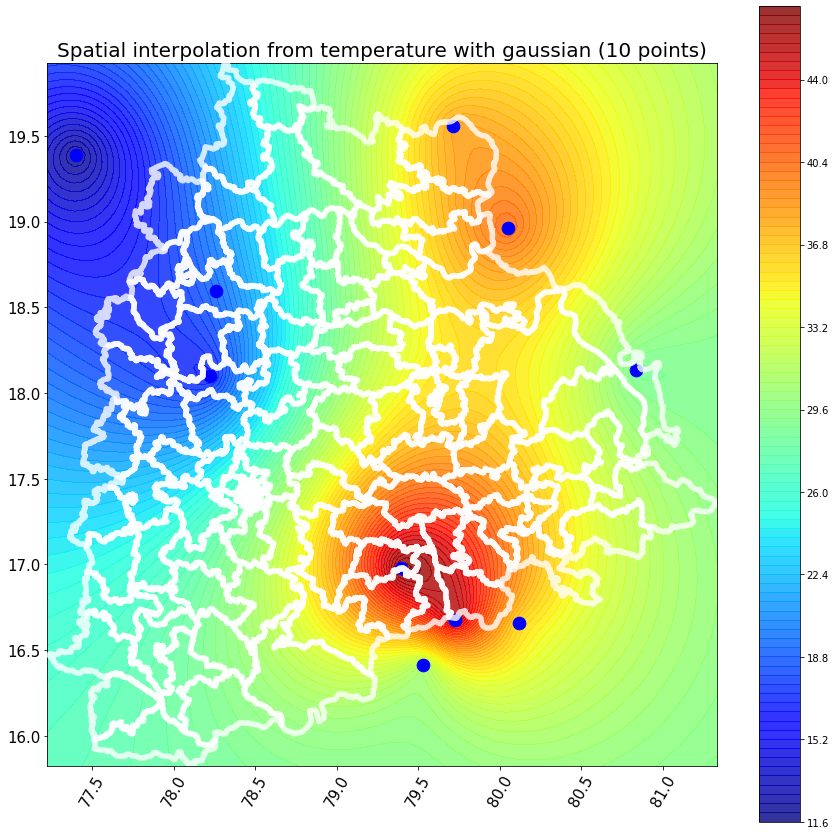

In [21]:
krigAndPlot(lons, lats, zdata, 'exponential')

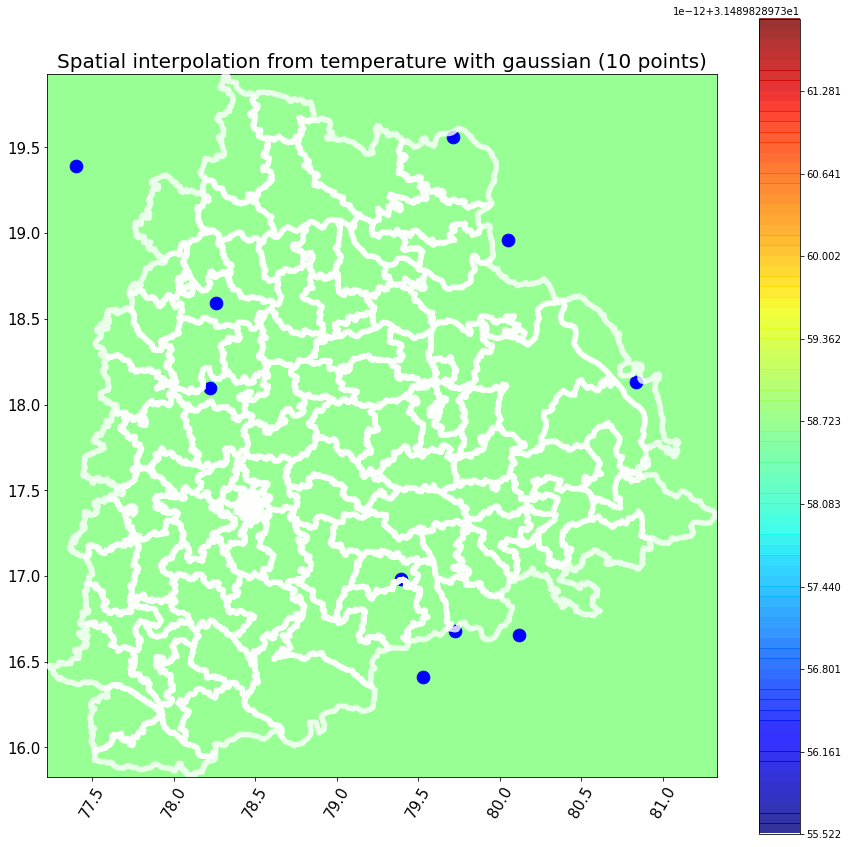

In [22]:
krigAndPlot(lons, lats, zdata, 'hole-effect')